<a href="https://colab.research.google.com/github/copiglet/Carvana-Image-Masking-Challenge/blob/main/vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 압축 해제


In [ ]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [ ]:
import numpy as np 
import pandas as pd
import os

for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/metadata.csv.zip
./input/sample_submission.csv.zip
./input/test.zip
./input/test_hq.zip
./input/train.zip
./input/train_hq.zip
./input/train_masks.csv.zip
./input/train_masks.zip


In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from pathlib import Path
import zipfile

In [ ]:
train_zip_path = './input/train.zip'
masks_zip_path = './input/train_masks.zip'
test_zip_path = './input/test.zip'

if not Path('./working/train').exists():
    with zipfile.ZipFile(train_zip_path,'r') as z:
        z.extractall('./working')
if not Path('./working/train_masks').exists():
    with zipfile.ZipFile(masks_zip_path,'r') as z:
        z.extractall('./working')
if not Path('./working/test').exists():
    pass

In [ ]:
print("train set:  ", len(os.listdir("./working/train")))
print("train masks:", len(os.listdir("./working/train_masks")))

train set:   5088
train masks: 5088


# 데이터 준비

In [ ]:
from glob import glob

root_dir = "./working"
train_path = os.path.join(root_dir, "train")
train_masks_path = os.path.join(root_dir, "train_masks")
#test_path = os.path.join(root_dir, "test")

train_filepaths = glob(os.path.join(train_path, "*.jpg"))
train_masks_filepaths = glob(os.path.join(train_masks_path, "*.gif"))
#test_filepaths = glob(os.path.join(test_path, "*.jpg"))

# 이미지의 독립적인 ids를 얻는과정
def get_root_name(filepaths):
    file_names = [os.path.basename(filepath) for filepath in filepaths]
    root_name = [name.split("_")[0] for name in file_names]
    return root_name

all_train_ids = set(get_root_name(train_filepaths))
all_train_masks_ids = set(get_root_name(train_masks_filepaths))
#all_test_ids = set(get_root_name(test_filepaths))

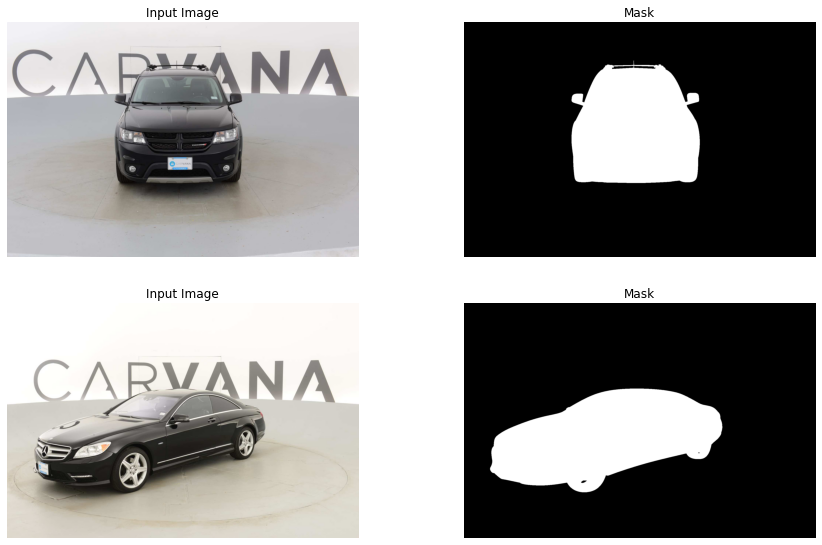

In [ ]:
def display_images(): # 이미지 시각화
    plt.figure(figsize=(15, 25))
    title = ['Input Image', 'Mask']

    for i in range(0, 4, 2):
        plt.subplot(5, 2, i+1)
        plt.title(title[0])
        path_img = root_dir + "/train/" + list(all_train_ids)[i] + f"_0{i+1}.jpg"
        plt.imshow(imread(path_img))
        plt.axis("off")

        plt.subplot(5, 2, i+2)
        plt.title(title[1])
        path_mask_img = root_dir + "/train_masks/" + list(all_train_ids)[i] + f"_0{i+1}_mask.gif"
        plt.imshow(imread(path_mask_img))
        plt.axis("off")
    plt.show()

display_images()

In [ ]:
def get_image_id(path):
    return os.path.splitext(os.path.basename(path))[0]

df = pd.DataFrame(dict(image_path=train_filepaths))
df['image_id'] = df['image_path'].map(lambda path: get_image_id(path))
df['mask_path'] = df['image_path'].map(
    lambda x: x.replace('train', 'train_masks').replace('.jpg', '_mask.gif'))
df['car_id'] = df['image_id'].map(lambda img_id: img_id.split('_')[0])

In [ ]:
df

,image_path,image_id,mask_path,car_id
0,./working/train/cf65b1c5e147_09.jpg,cf65b1c5e147_09,./working/train_masks/cf65b1c5e147_09_mask.gif,cf65b1c5e147
1,./working/train/cf65b1c5e147_10.jpg,cf65b1c5e147_10,./working/train_masks/cf65b1c5e147_10_mask.gif,cf65b1c5e147
2,./working/train/cf65b1c5e147_11.jpg,cf65b1c5e147_11,./working/train_masks/cf65b1c5e147_11_mask.gif,cf65b1c5e147
3,./working/train/cf65b1c5e147_12.jpg,cf65b1c5e147_12,./working/train_masks/cf65b1c5e147_12_mask.gif,cf65b1c5e147
4,./working/train/cf65b1c5e147_13.jpg,cf65b1c5e147_13,./working/train_masks/cf65b1c5e147_13_mask.gif,cf65b1c5e147
...,...,...,...,...
5083,./working/train/0789bed99cb8_04.jpg,0789bed99cb8_04,./working/train_masks/0789bed99cb8_04_mask.gif,0789bed99cb8
5084,./working/train/0789bed99cb8_05.jpg,0789bed99cb8_05,./working/train_masks/0789bed99cb8_05_mask.gif,0789bed99cb8
5085,./working/train/0789bed99cb8_06.jpg,0789bed99cb8_06,./working/train_masks/0789bed99cb8_06_mask.gif,0789bed99cb8
5086,./working/train/0789bed99cb8_07.jpg,0789bed99cb8_07,./working/train_masks/0789bed99cb8_07_mask.gif,0789bed99cb8


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(ids, col="car_id"):
    train_ids, valid_ids = train_test_split(ids, random_state=42, test_size=.2)
    valid_ids, test_ids = train_test_split(valid_ids, random_state=42, test_size=.5)
    train_df = df[df[col].isin(train_ids)]
    valid_df = df[df[col].isin(valid_ids)]
    test_df = df[df[col].isin(test_ids)]
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_data(list(all_train_ids))
print("train_df: ", train_df.shape[0])
print("valid_df: ", valid_df.shape[0])
print("test_df:  ", test_df.shape[0])

train_df:  4064
valid_df:  512
test_df:   512


# 데이터 전처리

In [ ]:
from tensorflow.image import stateless_random_crop, stateless_random_brightness

IMG_SIZE = [512, 512]
rng = tf.random.Generator.from_seed(1)

def decode(path):
    img = tf.io.read_file(path)  # 파일을 읽음
    img = tf.image.decode_jpeg(img, channels=3) # 이미지 파일을 디코딩 
    img = tf.image.resize(img, IMG_SIZE) # [512.512] 사이즈 크기로 이미지 변환
    img = img / 255.0
    return img

@tf.function
def preprocess(image_path, mask_path):
    image = decode(image_path)
    mask = decode(mask_path)
    mask = mask[:, :, :1] # take one channel
    return image, mask

@tf.function
def data_augmentation(image, mask): # 데이터 증식
    if rng.uniform(()) > 0.5: 
        image = tf.image.flip_left_right(image) # 이미지를 가로로 뒤집습니다 (왼쪽에서 오른쪽으로)
        mask = tf.image.flip_left_right(mask)

    seed = rng.make_seeds(2)[0]
    image = stateless_random_brightness(image, max_delta=0.1, seed=seed)
    return image, mask

def make_dataset(df, shuffle=False, augment=False, batch_size=16, buffer_size=1000):
    ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
    ds = ds.map(preprocess, num_parallel_calls=5)
    if shuffle:
        ds = ds.shuffle(buffer_size)
    if augment:
        ds = ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

train_data = make_dataset(train_df, shuffle=True, augment=True)
valid_data = make_dataset(valid_df)
test_data = make_dataset(test_df)

In [ ]:
train_data

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

In [ ]:
del df
del train_df
del valid_df
del test_df

# 모델링

In [ ]:
IMG_SIZE = [512, 512]

In [ ]:
def upsample(filters, size, strides):
    """Upsample the input"""

    initializer = tf.random_normal_initializer(0., 0.02) # 정규 분포로 텐서를 생성하는 이니셜 라이저 mean= 0 , stddev= 0.02

    result = Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                      padding="same",
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
   
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(input_shape=IMG_SIZE + [3], include_top=False, weights="imagenet") # input에 채널 정보를 추가

layers_names = [
    "block2_conv1",    # 256x256
    "block2_conv2",    # 256x256
    "block3_conv1",    # 128x128
    "block3_conv2",    # 128x128
    "block4_conv1",    # 64x64
    "block4_conv2",    # 64x64
    "block5_conv1",    # 32x32
]

layers = [base_model.get_layer(name).output for name in layers_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False


up_stack = [
    upsample(512, 3, 1),   # 32x32 -> 32x32
    upsample(512, 3, 2),   # 32x32 -> 64x64
    upsample(256, 3, 1),   # 64x64 -> 64x64 
    upsample(256, 3, 2),   # 64x64 -> 128x128
    upsample(128, 3, 1),   # 128x128 -> 128x128
    upsample(128, 3, 2),   # 128x128 -> 256x256
]     

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
def unet_generator(output_channels=1):
    inputs = tf.keras.layers.Input(shape=IMG_SIZE + [3])
    x = inputs

    initializer = tf.random_normal_initializer(0., 0.02)
    output = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding="same", kernel_initializer=initializer
    )
    
    concat = tf.keras.layers.Concatenate()

    # Downsampling 
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connection
    for up, skip in zip (up_stack, skips):
        x = up(x)
        print(x)
        if up.layers[0].strides == (2, 2):
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

    x = output(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_generator()

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='sequential/re_lu/Relu:0', description="created by layer 'sequential'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 512), dtype=tf.float32, name=None), name='sequential_1/re_lu_1/Relu:0', description="created by layer 'sequential_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='sequential_2/re_lu_2/Relu:0', description="created by layer 'sequential_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 256), dtype=tf.float32, name=None), name='sequential_3/re_lu_3/Relu:0', description="created by layer 'sequential_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 128), dtype=tf.float32, name=None), name='sequential_4/re_lu_4/Relu:0', description="created by layer 'sequential_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 128), dtype=tf.float32, name=None), name='sequential_5/re_lu_5/Relu:0', descripti

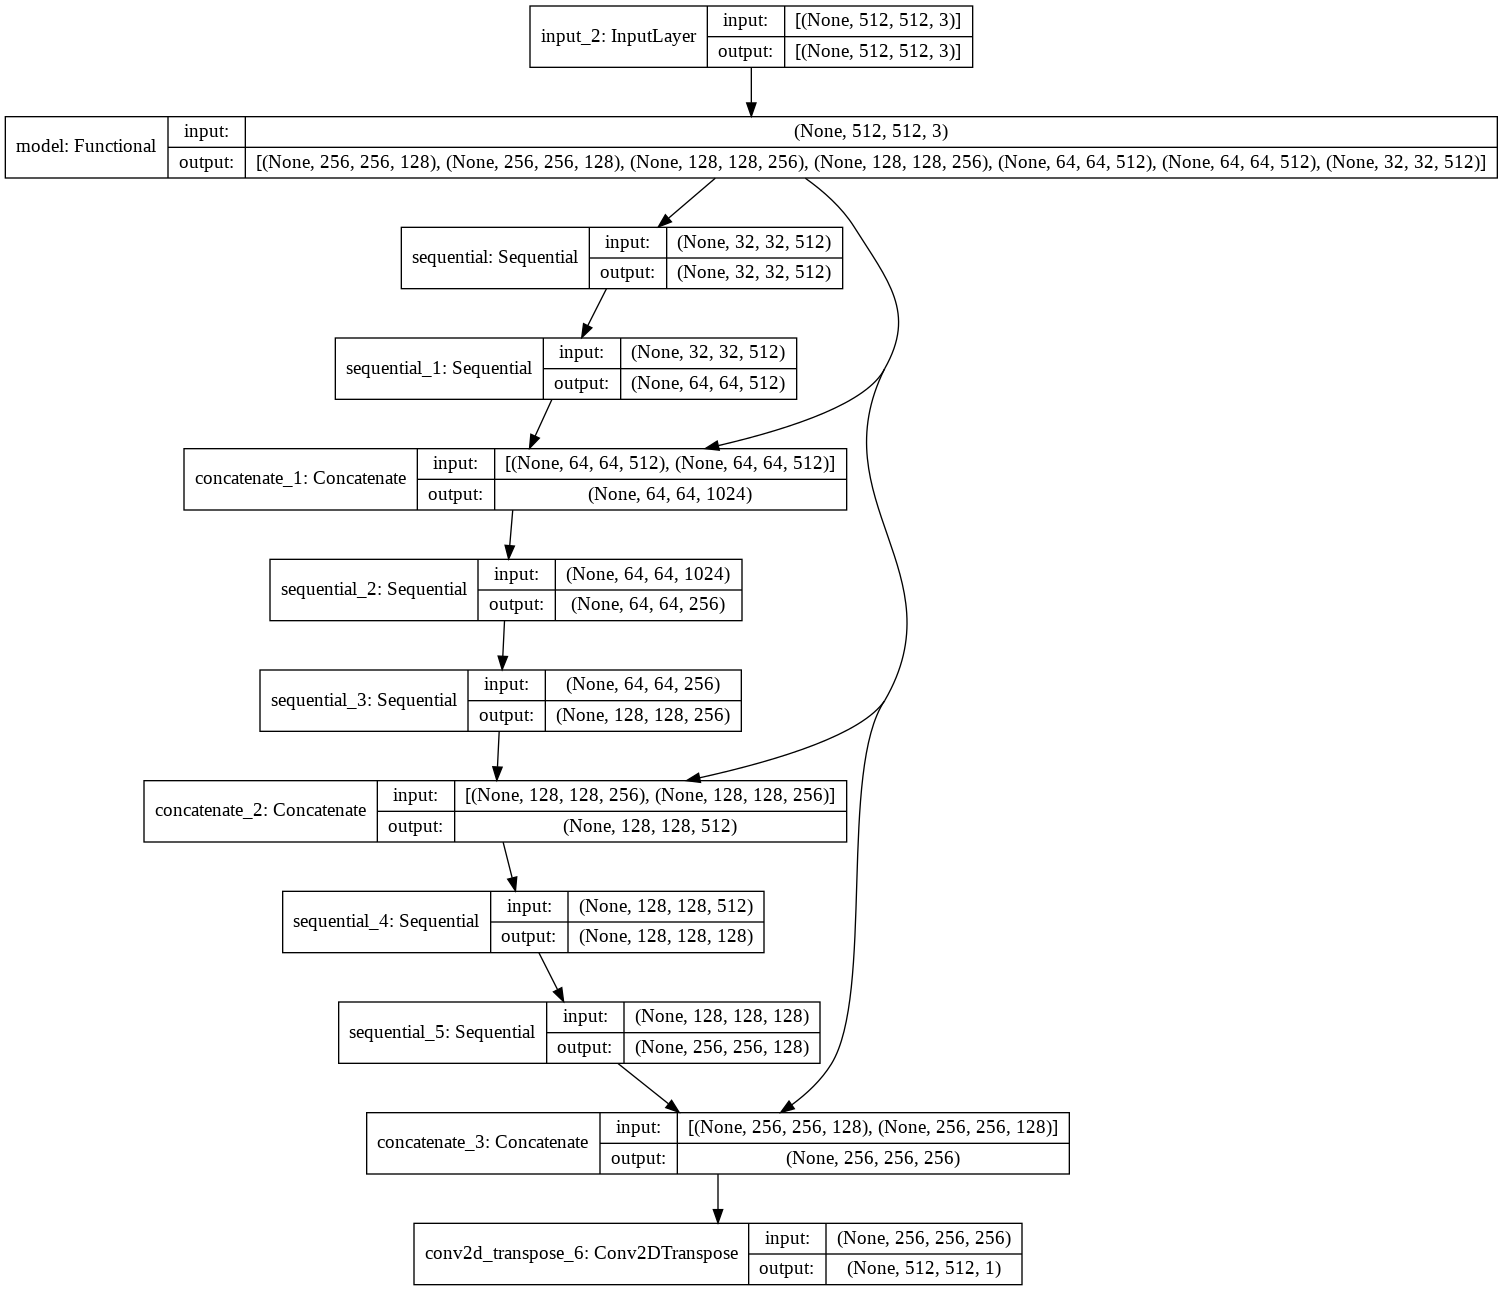

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
for images, masks in train_data.take(2):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

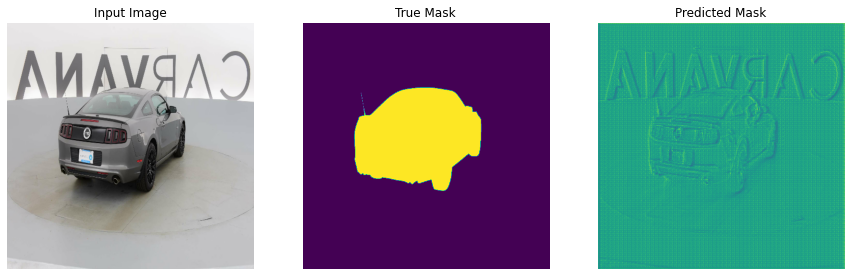

In [ ]:
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(IMG_SIZE[0],IMG_SIZE[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)

Epoch 1/20
254/254 [==============================] - 160s 562ms/step - loss: 0.0093 - accuracy: 0.9955 - val_loss: 0.0097 - val_accuracy: 0.9953
Epoch 2/20
254/254 [==============================] - 159s 564ms/step - loss: 0.0074 - accuracy: 0.9962 - val_loss: 0.0089 - val_accuracy: 0.9956
Epoch 3/20


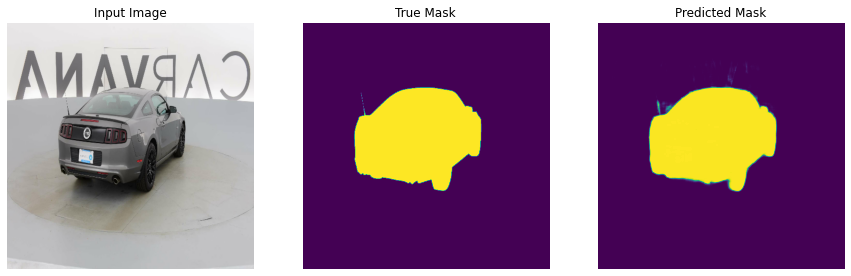

254/254 [==============================] - 158s 560ms/step - loss: 0.0063 - accuracy: 0.9965 - val_loss: 0.0080 - val_accuracy: 0.9961
Epoch 4/20
254/254 [==============================] - 158s 561ms/step - loss: 0.0058 - accuracy: 0.9967 - val_loss: 0.0073 - val_accuracy: 0.9963
Epoch 5/20
254/254 [==============================] - 158s 561ms/step - loss: 0.0055 - accuracy: 0.9968 - val_loss: 0.0068 - val_accuracy: 0.9965
Epoch 6/20


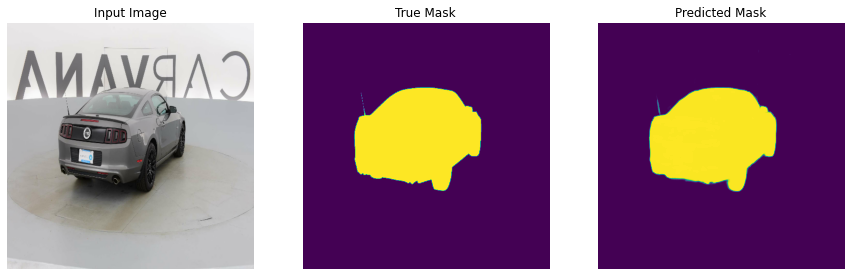

254/254 [==============================] - 158s 560ms/step - loss: 0.0053 - accuracy: 0.9969 - val_loss: 0.0068 - val_accuracy: 0.9965
Epoch 7/20
254/254 [==============================] - 159s 565ms/step - loss: 0.0050 - accuracy: 0.9970 - val_loss: 0.0066 - val_accuracy: 0.9965
Epoch 8/20
254/254 [==============================] - 157s 560ms/step - loss: 0.0049 - accuracy: 0.9971 - val_loss: 0.0070 - val_accuracy: 0.9965
Epoch 9/20


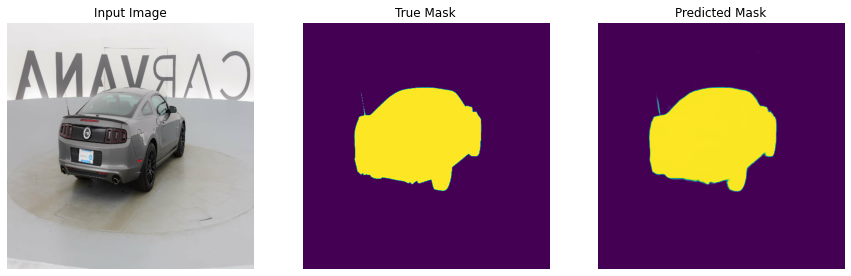

254/254 [==============================] - 159s 567ms/step - loss: 0.0047 - accuracy: 0.9971 - val_loss: 0.0068 - val_accuracy: 0.9965
Epoch 10/20
254/254 [==============================] - 159s 566ms/step - loss: 0.0048 - accuracy: 0.9971 - val_loss: 0.0070 - val_accuracy: 0.9965
Epoch 11/20
254/254 [==============================] - 158s 561ms/step - loss: 0.0053 - accuracy: 0.9969 - val_loss: 0.0076 - val_accuracy: 0.9962
Epoch 12/20


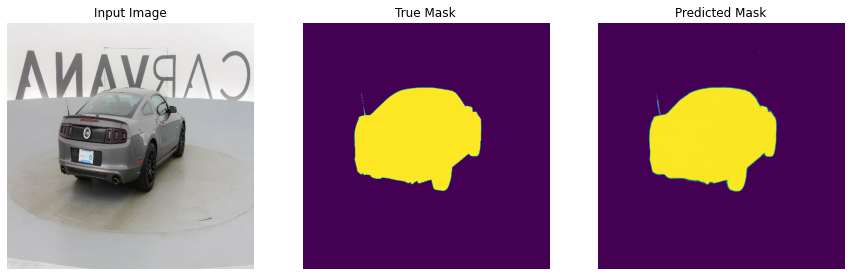

254/254 [==============================] - 158s 561ms/step - loss: 0.0045 - accuracy: 0.9972 - val_loss: 0.0062 - val_accuracy: 0.9967
Epoch 13/20
254/254 [==============================] - 157s 560ms/step - loss: 0.0043 - accuracy: 0.9973 - val_loss: 0.0067 - val_accuracy: 0.9966
Epoch 14/20
254/254 [==============================] - 157s 560ms/step - loss: 0.0043 - accuracy: 0.9973 - val_loss: 0.0078 - val_accuracy: 0.9964
Epoch 15/20


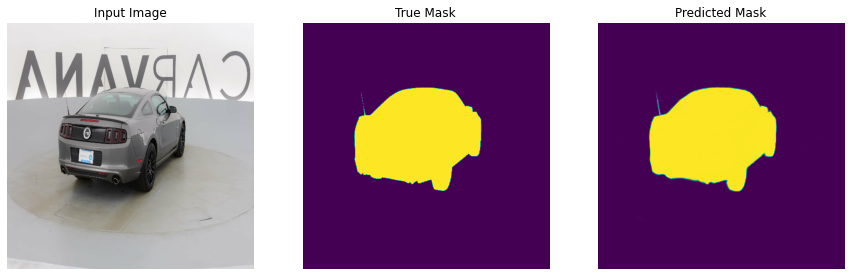

254/254 [==============================] - 157s 559ms/step - loss: 0.0051 - accuracy: 0.9970 - val_loss: 0.0169 - val_accuracy: 0.9951
Epoch 16/20
254/254 [==============================] - 158s 562ms/step - loss: 0.0047 - accuracy: 0.9971 - val_loss: 0.0065 - val_accuracy: 0.9966
Epoch 17/20
254/254 [==============================] - 156s 558ms/step - loss: 0.0042 - accuracy: 0.9973 - val_loss: 0.0060 - val_accuracy: 0.9967
Epoch 18/20


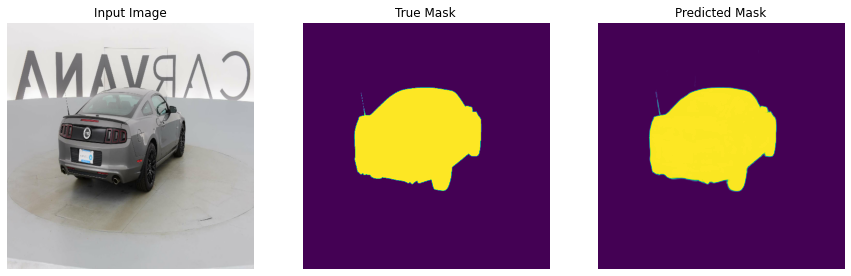

254/254 [==============================] - 157s 556ms/step - loss: 0.0041 - accuracy: 0.9974 - val_loss: 0.0063 - val_accuracy: 0.9967
Epoch 19/20
254/254 [==============================] - 157s 559ms/step - loss: 0.0040 - accuracy: 0.9974 - val_loss: 0.0064 - val_accuracy: 0.9967
Epoch 20/20
254/254 [==============================] - 158s 562ms/step - loss: 0.0040 - accuracy: 0.9974 - val_loss: 0.0065 - val_accuracy: 0.9967


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                    restore_best_weights=True)


epochs = 20

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
    
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model_history = model.fit(train_data, epochs=epochs,
                          validation_data=valid_data,
                          callbacks=[DisplayCallback(), early_stopping_cb])

# 시각화, 결과

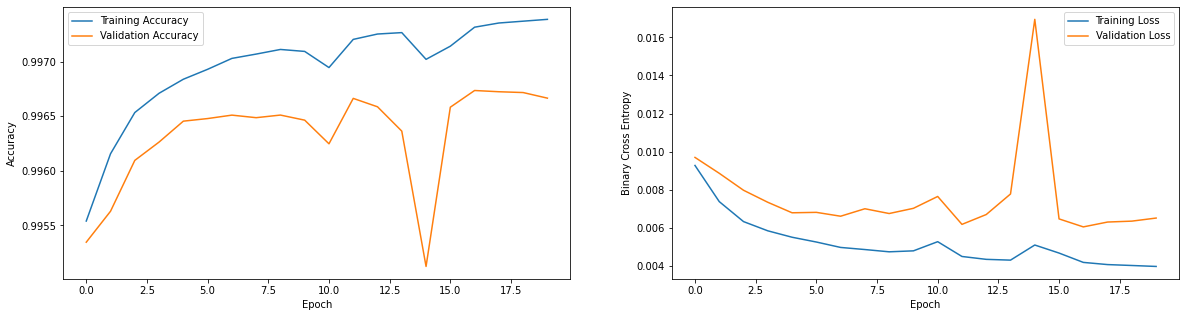

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend()
plt.show()

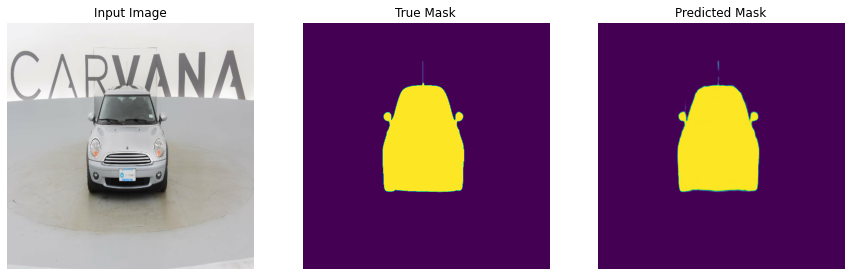

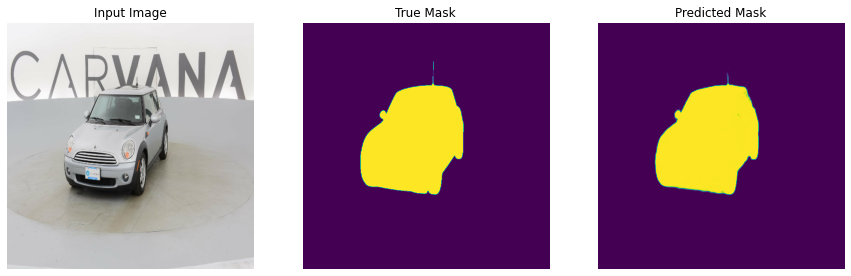

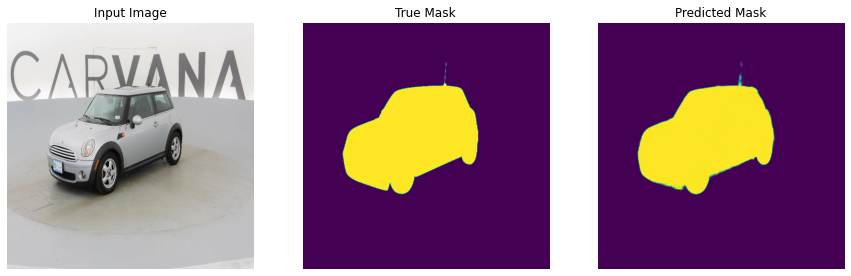

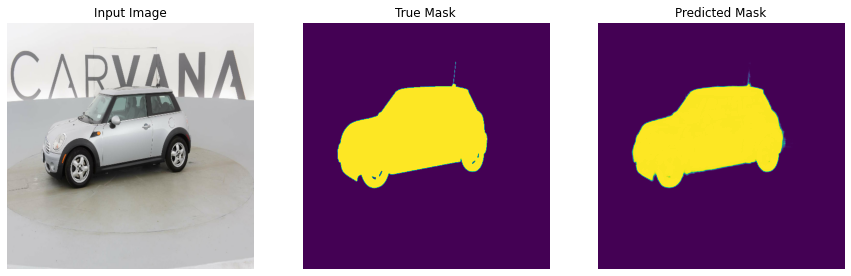

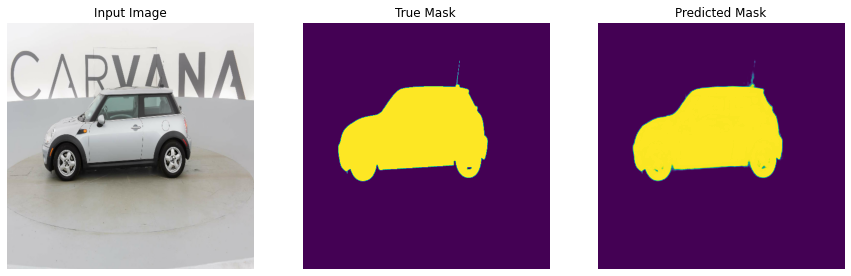

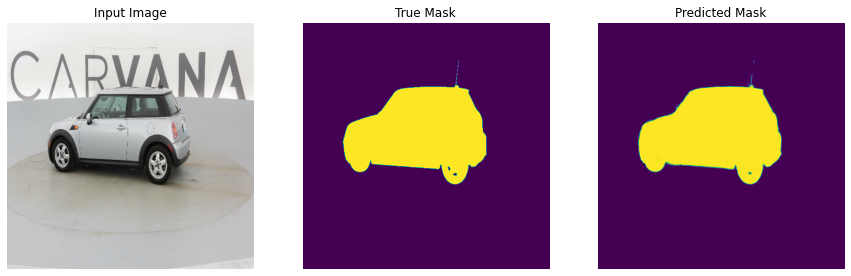

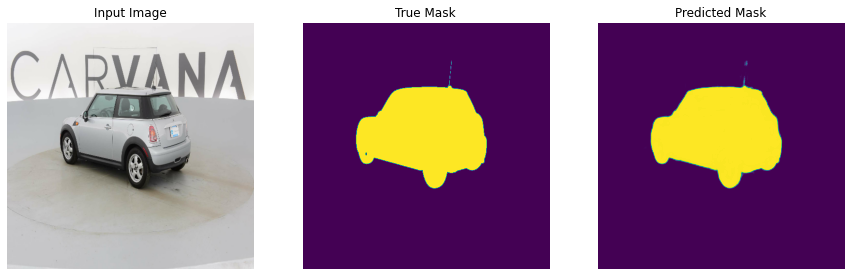

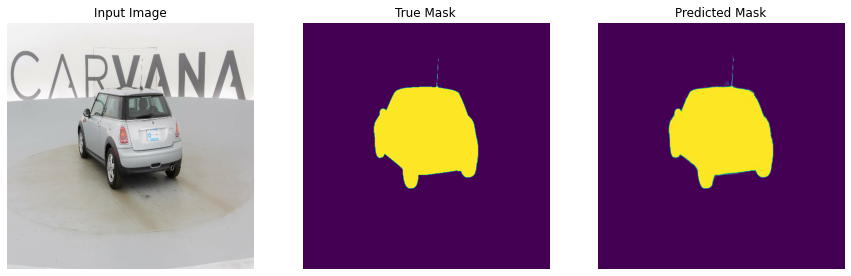

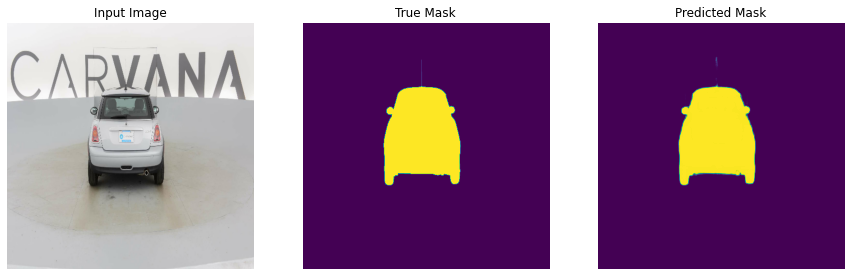

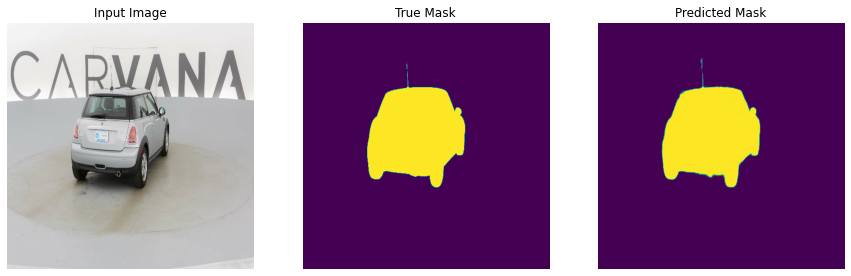

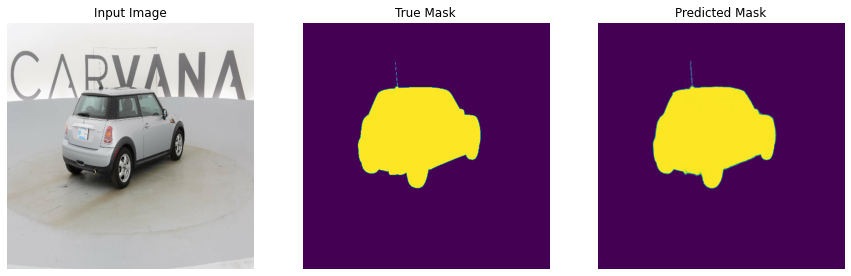

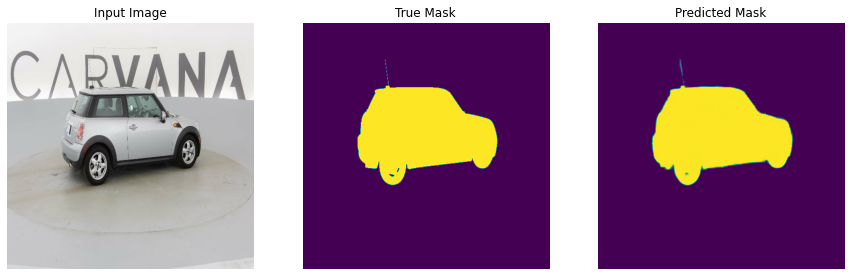

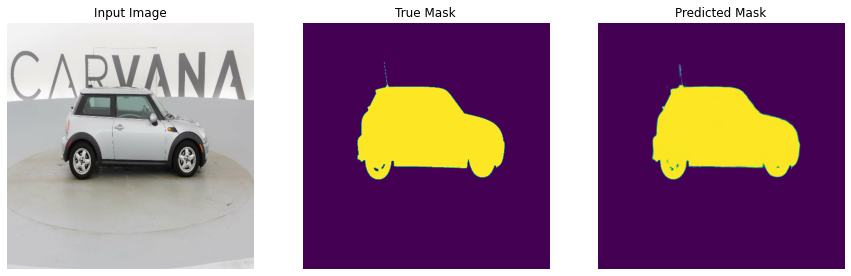

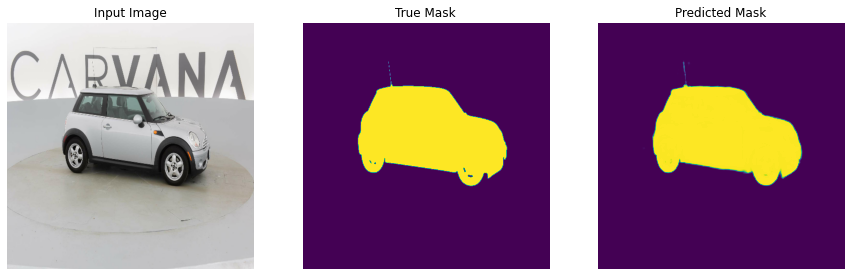

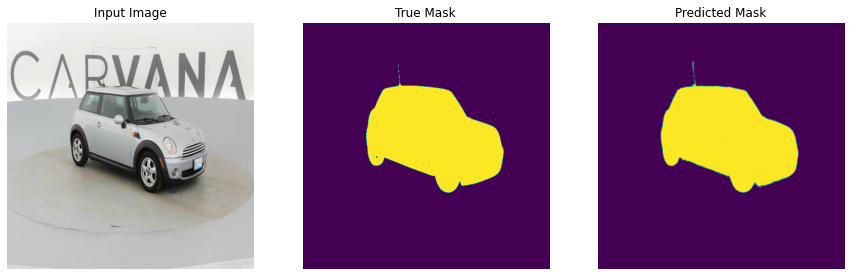

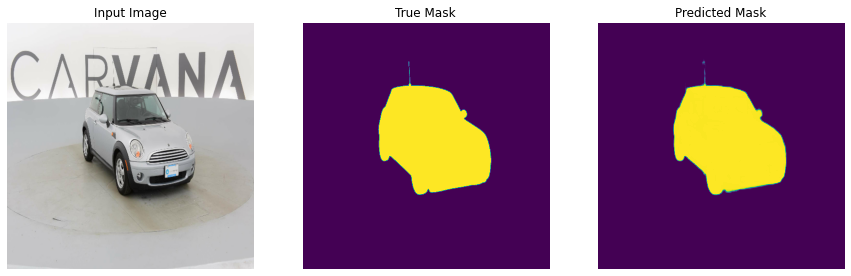

In [ ]:
for images, masks in test_data.take(1):
    for img, mask in zip(images, masks):
        show_predictions(img, mask)